load a .pth file (pre-trained neural network) 

In [2]:
import glob
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision as tv
from torchvision.utils import save_image, make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

from PIL import Image

import os
import time

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv1D,Conv2D, MaxPooling2D, Dense, Input, Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, concatenate, AveragePooling2D, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [4]:
dataset_root_dir = '/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Add noise 

In [5]:
# class NoisyBSDSDataset(td.Dataset):

#     def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
#         super(NoisyBSDSDataset, self).__init__()
#         self.mode = mode
#         self.image_size = image_size
#         self.sigma = sigma
#         self.images_dir = os.path.join(root_dir, mode)
#         self.files = os.listdir(self.images_dir)

#     def __len__(self):
#         return len(self.files)

#     def __repr__(self):
#         return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
#             format(self.mode, self.image_size, self.sigma)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.images_dir, self.files[idx])
#         clean = Image.open(img_path).convert('RGB')   
#         # random crop
#         i = np.random.randint(clean.size[0] - self.image_size[0])
#         j = np.random.randint(clean.size[1] - self.image_size[1])
        
#         clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
#         transform = tv.transforms.Compose([
#             # convert it to a tensor
#             tv.transforms.ToTensor(),
#             # normalize it to the range [−1, 1]
#             tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
#             ])
#         clean = transform(clean)
        
#         noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
#         return noisy, clean

In [7]:
# train_set = NoisyBSDSDataset(dataset_root_dir)
# test_set = NoisyBSDSDataset(dataset_root_dir, mode='test')

# x = test_set[5]

# fig, axes = plt.subplots(ncols=2)
# myimshow(x[0], ax=axes[0])
# axes[0].set_title('Noisy')

# myimshow(x[1], ax=axes[1])
# axes[1].set_title('Clean')
# print(f'image size is {x[0].shape}.')

## Load Data in test , train and validation df 

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [6]:
train_images = sorted(os.listdir('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/train'))
imgsize=(240,320,3)
train_image = []
for im in train_images:
    img = tf.keras.utils.load_img('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/train/'+ im)
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)
train_df.shape

(20, 240, 320, 3)

In [7]:
validation_images = sorted(os.listdir('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/validation'))
imgsize=(240,320,3)
validation_image = []
for im in validation_images:
    img = tf.keras.utils.load_img('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/validation/'+ im)
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    validation_image.append(img)
validation_df = np.array(train_image)
validation_df.shape

(20, 240, 320, 3)

In [8]:
# matplotlib displays color in BGR format, we are converting that to RGB
def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(1,3):
        ax[i-5].imshow(dataset[i].reshape(100,100), cmap='gray')
    plt.show()

In [9]:
noised_df= []

def add_noise(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.07
    return noisy

i=0
for img in train_df:
    noisy_img= add_noise(img)
    noised_df.append(noisy_img)
    noise_type="gauss"
    path="/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/train_noisy/"+noise_type+"_gnimg_"+str(i)+".jpg"
    cv2.imwrite(path, noisy_img)
    i=i+1
    
noised_df= np.array(noised_df)
noised_df.shape

(20, 240, 320, 3)

In [10]:
xtrain= train_df[0:7]
xtrain_noisy = noised_df[0:7]
# show_img(xtrain)
print(xtrain.shape)
print(xtrain_noisy.shape)

xtest= train_df[8:]
xtest_noisy= noised_df[8:]
# show_img(xtest)
print(xtest.shape)
print(xtest_noisy.shape)

(7, 240, 320, 3)
(7, 240, 320, 3)
(12, 240, 320, 3)
(12, 240, 320, 3)


In [11]:
#Custom function to plot/visualize noisy, ground truth and predicted images
def visualize(sample,model):
  fig,ax = plt.subplots(len(sample),3,figsize=(30,30))
  for i in range(len(sample)):
    path = sample['Ground Truth Images'].iloc[i]
    test_img_gt = cv2.imread(path)
    test_img_gt = cv2.cvtColor(test_img_gt, cv2.COLOR_BGR2RGB)
    test_img_gt = cv2.resize(test_img_gt,(512,512))
    test_img_gt = test_img_gt.astype("float32") / 255.0
  
    path = sample['Noisy Images'].iloc[i]
    test_img_nsy = cv2.imread(path)
    pred_img = prediction(test_img_nsy,model)
    pred_img = cv2.resize(pred_img,(512,512))

    test_img_nsy = cv2.cvtColor(test_img_nsy, cv2.COLOR_BGR2RGB)
    test_img_nsy = cv2.resize(test_img_nsy,(512,512))
    test_img_nsy = test_img_nsy.astype("float32") / 255.0
    
    ax[i][0].imshow(test_img_nsy)
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][0].title.set_text("Noisy Image")

    ax[i][1].imshow(test_img_gt)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)
    ax[i][1].title.set_text("Ground Truth Image")

    ax[i][2].imshow(pred_img)
    ax[i][2].get_xaxis().set_visible(False)
    ax[i][2].get_yaxis().set_visible(False)
    ax[i][2].title.set_text("Predicted Image")

# CBD Net

In [101]:
tf.keras.backend.clear_session()
input = Input(shape=(240, 320, 3))

#Noise estimation subnetwork
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(input)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(3, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)

#Non Blind denoising subnetwork
x = concatenate([x,input])
conv1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
conv2 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv1)

pool1 = AveragePooling2D(pool_size=(2,2),padding='same')(conv2)
conv3 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool1)
conv4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv3)
conv5 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv4)

pool2 = AveragePooling2D(pool_size=(2,2),padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool2)
conv7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv6)
conv8 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv7)
conv9 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv8)
conv10 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv9)
conv11 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv10)

upsample1 = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv11)
add1 = Add()([upsample1,conv5])
conv12 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv13 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv12)
conv14 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv13)

upsample2 = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv14)
add1 = Add()([upsample2,conv2])
conv15 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv16 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv15)

out = Conv2D(3, (1,1), kernel_initializer='he_normal',padding="same")(conv16)
out = Add()([out,input])

CBDNet = Model(input,out)
CBDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())

In [83]:
CBDNet.fit(xtrain_noisy, xtrain, 
                epochs=10, 
                shuffle=True, 
                validation_data=(xtest_noisy, xtest))

Epoch 1/10
1/1 [==============================] - 58s 58s/step - loss: 0.0059 - val_loss: 0.0056
Epoch 2/10
1/1 [==============================] - 54s 54s/step - loss: 0.0057 - val_loss: 0.0057
Epoch 3/10
1/1 [==============================] - 54s 54s/step - loss: 0.0057 - val_loss: 0.0056
Epoch 4/10
1/1 [==============================] - 54s 54s/step - loss: 0.0056 - val_loss: 0.0054
Epoch 5/10
1/1 [==============================] - 56s 56s/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/10
1/1 [==============================] - 54s 54s/step - loss: 0.0053 - val_loss: 0.0052
Epoch 7/10
1/1 [==============================] - 54s 54s/step - loss: 0.0052 - val_loss: 0.0051
Epoch 8/10
1/1 [==============================] - 54s 54s/step - loss: 0.0051 - val_loss: 0.0050
Epoch 9/10
1/1 [==============================] - 56s 56s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/10
1/1 [==============================] - 54s 54s/step - loss: 0.0050 - val_loss: 0.0050


In [32]:
CBDNet_denoised_imgs= CBDNet.predict(validation_df)

In [33]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(validation_df[0])
axes[0].axis('off')
axes[0].set_title('Noisy')

axes[1].imshow(CBDNet_denoised_imgs[0])
axes[1].axis('off')
# myimshow( model.predict(xtest_noisy[3]), ax=axes[1])
axes[1].set_title('Clean')

### CBD Densoing analysis

In [118]:
import skimage.metrics as measure

print('PSNR before denoising :',  measure.peak_signal_noise_ratio(train_df[1],noised_df[1]))
print('PSNR after denoising :', measure.peak_signal_noise_ratio(train_df[1],noised_df[1]))
print('SSIM before denoising :',measure.structural_similarity(train_df[1],noised_df[1],multichannel=True))
print('SSIM after denoising :', measure.structural_similarity(train_df[1],noised_df[1],multichannel=True))


print('PSNR after denoising :', measure.peak_signal_noise_ratio(validation_df[1],CBDNet_denoised_imgs[1]))
print('SSIM after denoising :', measure.structural_similarity(validation_df[1],CBDNet_denoised_imgs[1],multichannel=True))


print('PSNR after denoising :', measure.peak_signal_noise_ratio(validation_df[2],CBDNet_denoised_imgs[2]))
print('SSIM after denoising :', measure.structural_similarity(validation_df[2],CBDNet_denoised_imgs[2],multichannel=True))

PSNR before denoising : 23.104860418150608
PSNR after denoising : 23.104860418150608
SSIM before denoising : 0.5222668777833754
SSIM after denoising : 0.5222668777833754
PSNR after denoising : 8.76461660912935
SSIM after denoising : 0.10418759113732216
PSNR after denoising : 11.213258593845389
SSIM after denoising : 0.1445819029671556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [34]:
def plot_predictions(Noisy,Denoised):    
    f, ax = plt.subplots(2, 5)
    f.set_size_inches(12,10)
    for i in range(5):
        # ax[0][i].imshow(tf.squeeze(GT[i]))
        # ax[0][i].set_title("original")
        # ax[0][i].axis('off')

        ax[0][i].imshow(tf.squeeze(Noisy[i]))
        ax[0][i].set_title("noisy")
        ax[0][i].axis('off')

        ax[1][i].imshow(tf.squeeze(Denoised[i]))
        ax[1][i].set_title("denoised_imgs")
        ax[1][i].axis('off')
    plt.tight_layout()

1/1 [==============================] - 8s 8s/step


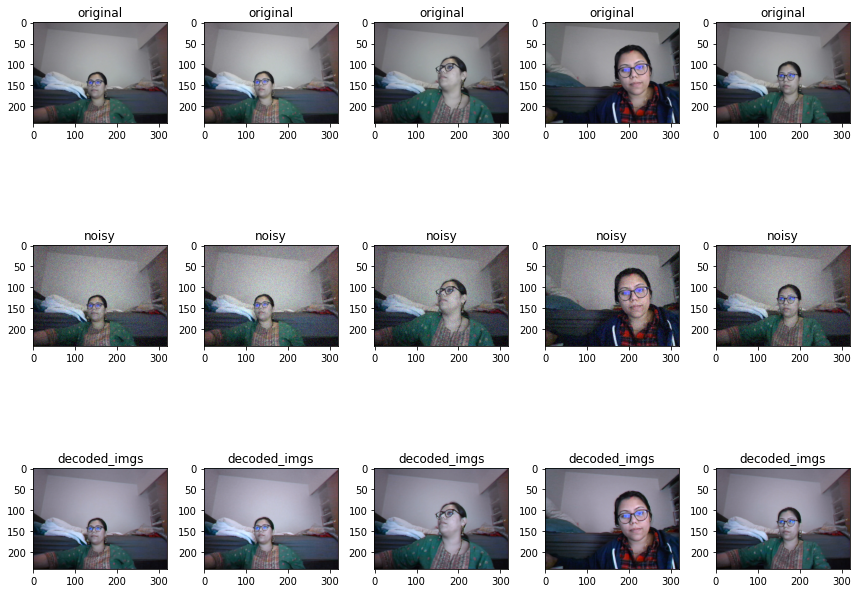

In [50]:
# import cv2
plot_predictions(validation_df[:5], CBDNet_denoised_imgs[:5])

# RIDNET

Residual Image Denoising Network Refer the research paper for detailed explanation : https://arxiv.org/pdf/1904.07396v2.pdf

In [25]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, MaxPooling2D, Add, Reshape, concatenate, AveragePooling2D, Multiply, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,Softmax
import pandas as pd

class EAM(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    
    self.conv1 = Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')
    self.conv2 = Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu') 

    self.conv3 = Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')
    self.conv4 = Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')

    self.conv5 = Conv2D(64, (3,3),padding='same',activation='relu')

    self.conv6 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv7 = Conv2D(64, (3,3),padding='same')

    self.conv8 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv9 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv10 = Conv2D(64, (1,1),padding='same')

    self.gap = GlobalAveragePooling2D()

    self.conv11 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv12 = Conv2D(64, (3,3),padding='same',activation='sigmoid')

  def call(self,input):
    conv1 = self.conv1(input)
    conv1 = self.conv2(conv1)

    conv2 = self.conv3(input)
    conv2 = self.conv4(conv2)

    concat = concatenate([conv1,conv2])
    conv3 = self.conv5(concat)
    add1 = Add()([input,conv3])

    conv4 = self.conv6(add1)
    conv4 = self.conv7(conv4)
    add2 = Add()([conv4,add1])
    add2 = Activation('relu')(add2)

    conv5 = self.conv8(add2)
    conv5 = self.conv9(conv5)
    conv5 = self.conv10(conv5)
    add3 = Add()([add2,conv5])
    add3 = Activation('relu')(add3)

    gap = self.gap(add3)
    gap = Reshape((1,1,64))(gap)
    conv6 = self.conv11(gap)
    conv6 = self.conv12(conv6)
    
    mul = Multiply()([conv6, add3])
    out = Add()([input,mul]) # This is not included in the reference code
    return out
  
tf.keras.backend.clear_session()
input = Input(shape=(240, 320, 3))

conv1 = Conv2D(64, (3,3),padding='same')(input)
eam1 = EAM()(conv1)
eam2 = EAM()(eam1)
eam3 = EAM()(eam2)
eam4 = EAM()(eam3) 
conv2 = Conv2D(3, (3,3),padding='same')(eam4)
out = Add()([conv2,input])

RIDNet = Model(input,out)
RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())


In [ ]:
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

conv1 = Conv2D(64, (3,3),padding='same')(input)
eam1 = EAM()(conv1)
eam2 = EAM()(eam1)
eam3 = EAM()(eam2)
eam4 = EAM()(eam3)
#add = Add()([eam4,conv1])  
conv2 = Conv2D(3, (3,3),padding='same')(eam4)
out = Add()([conv2,input])

RIDNet = Model(input,out)
RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
RIDNet.summary()

In [ ]:
# batch_size=8
# train_dataloader = Dataloder(xtrain_noisy,xtarin, batch_size, shuffle=True)
# test_dataloader = Dataloder(xtest_noisy,xtest,batch_size, shuffle=True)

In [ ]:
# log_dir="logs/model_4"
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
# reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=4,min_delta=0.00001)
# callback = [tensorboard,reducelr]
# RIDNet.fit(train_dataloader,shuffle=True,epochs=20,validation_data= test_dataloader, callbacks=callback)

In [ ]:
# RIDNet.fit(train_dataloader,shuffle=True,epochs=25,initial_epoch=20,validation_data= test_dataloader, callbacks=callback)
# RIDNet.save('RIDNet.h5')

In [14]:
RIDNet = tf.keras.models.load_model('/content/RIDNet.h5',custom_objects={'EAM':EAM})

#  Model downloaded fom https://github.com/sharathsolomon/ImageDenoising

In [35]:

start = time.time()
RIDNet_denoised_imgs= RIDNet.predict(validation_df)
end = time.time()
print("RIDNet_denoised_imgs Elapsed time:"+ str(end-start))

1/1 [==============================] - 87s 87s/step
Elapsed time:142.05647468566895


Text(0.5, 1.0, 'Clean')

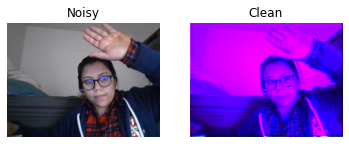

In [27]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(validation_df[0])
axes[0].axis('off')
axes[0].set_title('Noisy')

axes[1].imshow(denoised_imgs[0])
axes[1].axis('off')
axes[1].set_title('Clean')

In [ ]:
plot_predictions(validation_df[:5], RIDNet_denoised_imgs[:5])

# HiGAN

In [27]:
class MainNet(nn.Module):
    """B-DenseUNets"""
    def __init__(self, in_nc=12, out_nc=12):
        super(MainNet, self).__init__()
        self.inc = nn.Sequential(
            single_conv(in_nc, 64),
            single_conv(64, 64),
        )
        self.down1 = nn.AvgPool2d(2)
        self.conv1 = nn.Sequential(
            single_conv(64, 128),
            RDB(128, 4, 32),
        )
        self.down2 = nn.AvgPool2d(2)
        self.conv2 = nn.Sequential(
            single_conv(128, 256),
            RDB(256, 10, 32),
        )
        self.up1 = up(256)
        self.conv3 = nn.Sequential(
            RDB(128, 6, 32),
        )
        self.up2 = up(128)
        self.conv4 = nn.Sequential(
            RDB(64, 4, 32),
        )
        self.outc = outconv(64, out_nc)
    def forward(self, x):
        inx = self.inc(x)

        down1 = self.down1(inx)
        conv1 = self.conv1(down1)

        down2 = self.down2(conv1)
        conv2 = self.conv2(down2)

        up1 = self.up1(conv2, conv1)
        conv3 = self.conv3(up1)

        up2 = self.up2(conv3, inx)
        conv4 = self.conv4(up2)

        out = self.outc(conv4)
        return out


In [25]:
class HI_GAN(nn.Module):
    def __init__(self, ):
        super(HI_GAN, self).__init__()
        self.main = MainNet(in_nc=6, out_nc=6)
        self.main2 = MainNet(in_nc=12, out_nc=12)
        self.main3 = MainNet(in_nc=24, out_nc=24)
        self.out = nn.Conv2d(24, 3, kernel_size=3, padding=1, bias=True)
    def forward(self, unet_nd_dn, unet_d_dn):
        concat_img1 = torch.cat([unet_nd_dn, unet_d_dn], dim=1)
        out1 = 0.2*self.main(concat_img1) + concat_img1

        concat_img2 = torch.cat([concat_img1, out1], dim=1)
        out2 = 0.2*self.main2(concat_img2) + concat_img2

        concat_img3 = torch.cat([concat_img2, out2], dim=1)
        out3 = 0.2*self.main3(concat_img3) + concat_img3

        out = 0.2 * self.out(out3) + 0.5 * unet_nd_dn + 0.5 * unet_d_dn
        return out

In [28]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Create models
# unetnd = UNet_ND().to(device)
# unetd = UNet_D().to(device)
higan = HI_GAN().to(device)

NameError: ignored

In [13]:
# unetnd_path = 'models/unet_nd.pth'
# unetd_path = 'models/unet_d.pth'
higan_path = '/content/hi_gan.pth'

In [14]:
# unetnd.load_state_dict(torch.load(unetnd_path), strict=False)
# unetd.load_state_dict(torch.load(unetd_path), strict=False)
higan.load_state_dict(torch.load(higan_path))

NameError: ignored

In [ ]:
imorig = cv2.imread("/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/test/SaltPepperNoise_gnimg.jpg")
imorig = imorig[:, :, ::-1] / 255.0
imorig = np.array(imorig).astype('float32')

imorig = np.expand_dims(imorig.transpose(2, 0, 1), 0)
imorig = torch.Tensor(imorig).to(device)

with torch.no_grad():
    gt_dn = unetnd(imorig)
    gf_dn = unetd(imorig)
    higan_dn = higan(gf_dn, gt_dn)

In [12]:
# Load
model = Net()
model.load_state_dict(torch.load("/content/hi_gan.pth"))
model.eval()

NameError: ignored

DnCNN

In [10]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

NameError: ignored

In [ ]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)
    
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

In [ ]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [ ]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

In [ ]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/denoising1", perform_validation_during_training=True)

In [ ]:

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

In [ ]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[12]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.init as init


# class DnCNN(nn.Module):
#     # reference: https://github.com/cszn/DnCNN/tree/master/TrainingCodes/dncnn_pytorch
#     def __init__(self, depth=17, n_channels=64, image_channels=1, 
#         use_bnorm=True, kernel_size=3):
#         super(DnCNN, self).__init__()
#         kernel_size = 3
#         padding = 1
#         layers = []

#         layers.append(nn.Conv2d(image_channels, n_channels, 
#             kernel_size=kernel_size, padding=padding, bias=True))
#         layers.append(nn.ReLU(inplace=True))
#         for _ in range(depth-2):
#             layers.append(nn.Conv2d(n_channels, n_channels, 
#             kernel_size=kernel_size, padding=padding, bias=False))
#             if use_bnorm:
#                 layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
#             layers.append(nn.ReLU(inplace=True))
#         layers.append(nn.Conv2d(n_channels, image_channels, 
#             kernel_size=kernel_size, padding=padding, bias=False))
#         self.dncnn = nn.Sequential(*layers)
#         self._initialize_weights()

#         print(f'model size: {self._model_size()}')

#     def forward(self, x):
#         y = x
#         out = self.dncnn(x)
#         # out: residual, y: noisy input
#         return y - out

#     def _initialize_weights(self):
#         print('init weight')
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 init.orthogonal_(m.weight)
#                 if m.bias is not None:
#                     init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 init.constant_(m.weight, 1)
#                 init.constant_(m.bias, 0)

#     def _model_size(self):
#         n_params, n_conv_layers = 0, 0
#         for param in self.parameters():
#             n_params += param.numel()
#         for module in self.modules():
#             if 'Conv' in module.__class__.__name__ \
#                     or 'conv' in module.__class__.__name__:
#                 n_conv_layers += 1
#         return n_params, n_conv_layers

In [ ]:
# class DnCNN_NRL(nn.Module):
#     """Non-residual learning.
#     """
#     def __init__(self, depth=17, n_channels=64, image_channels=1, 
#         use_bnorm=True, kernel_size=3):
#         super(DnCNN_NRL, self).__init__()
#         kernel_size = 3
#         padding = 1
#         layers = []

#         layers.append(nn.Conv2d(image_channels, n_channels, 
#             kernel_size=kernel_size, padding=padding, bias=True))
#         layers.append(nn.ReLU(inplace=True))
#         for _ in range(depth-2):
#             layers.append(nn.Conv2d(n_channels, n_channels, 
#             kernel_size=kernel_size, padding=padding, bias=False))
#             if use_bnorm:
#                 layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
#             layers.append(nn.ReLU(inplace=True))
#         layers.append(nn.Conv2d(n_channels, image_channels, 
#             kernel_size=kernel_size, padding=padding, bias=False))
#         self.dncnn = nn.Sequential(*layers)
#         self._initialize_weights()

#         print(f'model size: {self._model_size()}')

#     def forward(self, x):
#         # output denoised directly
#         return self.dncnn(x)

#     def _initialize_weights(self):
#         print('init weight')
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 init.orthogonal_(m.weight)
#                 if m.bias is not None:
#                     init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 init.constant_(m.weight, 1)
#                 init.constant_(m.bias, 0)

#     def _model_size(self):
#         n_params, n_conv_layers = 0, 0
#         for param in self.parameters():
#             n_params += param.numel()
#         for module in self.modules():
#             if 'Conv' in module.__class__.__name__ \
#                     or 'conv' in module.__class__.__name__:
#                 n_conv_layers += 1
#         return n_params, n_conv_layers

In [36]:
# model = torch.load('/content/dncnn.pth',map_location=torch.device('cpu'))
# print(model)

model = DnCNN(depth=17,
                  n_channels=64,
                  image_channels=1,
                  use_bnorm=True,
                  kernel_size=3)
model.load_state_dict(torch.load('/content/dncnn.pth',map_location=torch.device('cpu')))

NameError: ignored

In [ ]:
model.eval()

In [ ]:
img=cv2.imread("/content/SaltPepperNoise_gnimg.jpg")

In [ ]:
start = time.time()
denoised = model.dncnn.eval()
denoised.(img)
end = time.time()
print("Elapsed time:"+ end-start)